In [21]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


### LER IMAGEM COM OPENCV

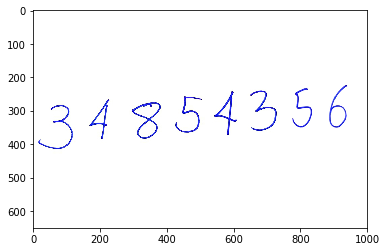

In [22]:
img = cv.imread("numbers.jpg")

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

### CONVERTER PARA ESCALA DE CINZA

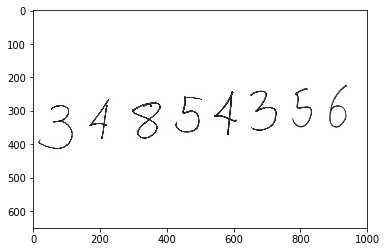

In [23]:
im_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(im_gray,cmap='gray')
plt.show()

O desfoque gaussiano é altamente eficaz na remoção do ruído gaussiano da imagem.

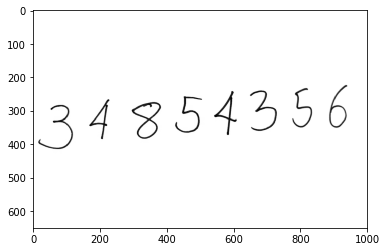

In [24]:
im_gauss = cv.GaussianBlur(im_gray, (5, 5), 0)

plt.imshow(im_gauss,cmap='gray')
plt.show()

***cv2.threshold***

Threshold traz a ideia de uma simplificação da imagem para facilitar análise, trazendo onde estão os limites da imagem em questão.

argumentos da função:

- 1 - Uma imagem em tons de cinza
- 2 - Limiar de intensidade para binarização
- 3 - 255 intensidade máxima
- 4 - Transforma em binário 
    - THRESH_BINARY      - Binário Normal
    - THRESH_BINARY_INV  - Binário invertido


A função ***cv.adaptiveThreshold*** também faz análise adaptativa

### BUSCANDO O LIMIAR DA IMAGEM

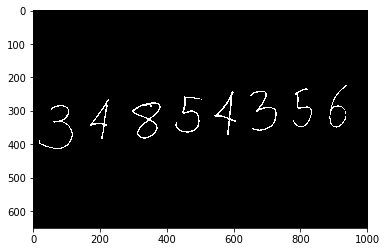

In [25]:
#  im_gray.max() TEM A INTENSIDADE MÁXIMA DA IMAGEM

ret, im_th = cv.threshold(im_gauss, im_gray.max()/2, im_gray.max(), cv.THRESH_BINARY_INV)

plt.imshow(im_th,cmap='gray')
plt.show()

### BUSCAR CONTORNOS DA IMAGEM

In [26]:
ctrs, hier = cv.findContours(im_th.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

##### CRIAR RETÂNGULOS DOS CONTORNOS

In [27]:
rects = [cv.boundingRect(ctr) for ctr in ctrs]
rects

[(17, 284, 101, 131),
 (296, 276, 86, 108),
 (169, 267, 59, 118),
 (425, 258, 78, 108),
 (541, 243, 66, 130),
 (649, 241, 78, 119),
 (775, 234, 58, 116),
 (885, 225, 52, 126)]

### ORDENANDO POSIÇÃO DOS RETÂNGULOS DA ESQUEDA PARA DIREITA

In [28]:
rects.sort()
rects

[(17, 284, 101, 131),
 (169, 267, 59, 118),
 (296, 276, 86, 108),
 (425, 258, 78, 108),
 (541, 243, 66, 130),
 (649, 241, 78, 119),
 (775, 234, 58, 116),
 (885, 225, 52, 126)]

### CRIAR ÁREA SELECIONÁVEL

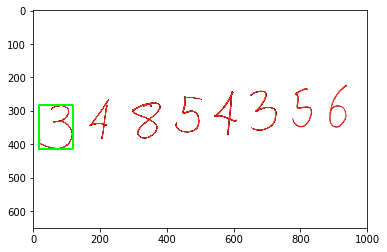

In [29]:
## CRIAR RETÂNGULOS NA IMAGEM ORIGINAL

  # DESENHAR RETANGULOS   

    #  x1,y1 ------
    #  |          |
    #  |          |
    #  |          |
    #  --------x2,y2

## selecionando propriedades do retângulo
x, y, w, h = rects[0]

## desenhando retângulo
cv.rectangle(img,  (x, y),  (x+w,y+h),  (0, 255, 0), 3) 

plt.imshow(img)
plt.show()


## SELECIONAR NÚMERO

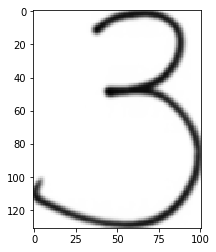

In [30]:
start_row = y
end_row   = y + h
    
start_col = x
end_col   = x + w

new_roi = im_gauss[ start_row : end_row,  start_col : end_col]

plt.imshow(new_roi, cmap='gray')
plt.show()

### RESIZE & PADDING

In [31]:
## TAMANHO DESEJADO
tam_final = 28

## TAMANHO ORIGINAL
old_size = new_roi.shape[:2]

## VERIFICANDO PROPORÇÃO
ratio = float(tam_final*0.8)/max(old_size)

## ALTERANDO PROPORÇÃO
new_size = tuple([int(x*ratio) for x in old_size])

## REDIMENSIONANDO IMAGEM USANDO PROPORÇÃO
new_roi = cv.resize(new_roi, (new_size[1], new_size[0]), interpolation=cv.INTER_AREA)

## PADDING
delta_w = tam_final - new_size[1]
delta_h = tam_final - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

## CRIANDO UMA BORDA ESCURA
color = [255, 255, 255]
new_im = cv.copyMakeBorder(new_roi, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)

new_im = cv.bitwise_not(new_im)

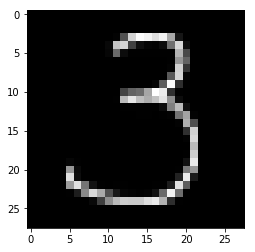

In [32]:
plt.imshow(new_im, cmap='gray')
plt.show()

### ROI = Region of Interest

In [33]:
rois = []

## TAMANHO DESEJADO
tam_final = 28

for rect in rects:
    ## selecionando propriedades do retângulo
    x, y, w, h = rect
  
    ## desenhando retângulo
    cv.rectangle(img,  (x, y),  (x+w,y+h),  (0, 255, 0), 1) 
    
    start_row = y
    end_row   = y + h  
    start_col = x
    end_col   = x + w

    new_roi = im_gauss[ start_row : end_row,  start_col : end_col]

     

    ## TAMANHO ORIGINAL
    old_size = new_roi.shape[:2]

    ## VERIFICANDO PROPORÇÃO
    ratio = float(tam_final*0.8)/max(old_size)

    ## ALTERANDO PROPORÇÃO
    new_size = tuple([int(x*ratio) for x in old_size])

    ## REDIMENSIONANDO IMAGEM USANDO PROPORÇÃO
    new_roi = cv.resize(new_roi, (new_size[1], new_size[0]))

    ## PADDING
    delta_w = tam_final - new_size[1]
    delta_h = tam_final - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    ## CRIANDO UMA BORDA ESCURA
    color = [255, 255, 255]
    new_im = cv.copyMakeBorder(new_roi, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)
    
    ## inverte imagem 
    new_im = cv.bitwise_not(new_im)
    
    rois.append(new_im)
    
rois = np.array(rois)

In [34]:
rois.shape[0]

8

## IMPORTANDO O MODELO

In [35]:
import h5py

In [36]:
from tensorflow.keras.models import load_model

In [37]:
model = load_model("Carteiro.h5")

In [38]:
i=0
for roi in rois:
    roi = roi.reshape((1, 28*28))
    preds = model.predict_classes(roi)
    
    pos = rects[i]        
    cv.putText(img, str(preds[0]), (pos[0], pos[1]), cv.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), 1)
    
    i = i+1
    

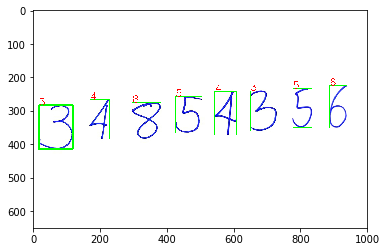

In [39]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

In [40]:
cv.imshow("PLOTANTO IMAGEM COM OPENcv", img)
cv.waitKey()

-1